# Fine-tuning InceptionV3 for food nutrition classifier

In [1]:
import tensorflow as tf
#suppress "INFO:tensorflow:Summary name .... is illegal; using ... instead." warnings.
tf.logging.set_verbosity(tf.logging.WARN)

from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dropout
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.callbacks import TensorBoard
from download import download_file
import os.path
import numpy as np

Using TensorFlow backend.


### Database parameters

In [2]:
# Set metadata database paths
download_file('https://s3-eu-west-1.amazonaws.com/redbase/data.sqlite', 'data.sqlite')
database_path = 'data.sqlite'

# Set image database paths
download_file('https://s3-eu-west-1.amazonaws.com/redbase/image_data_299.sqlite', 'image_data_299.sqlite')
image_data_database_path = 'image_data_299.sqlite'

# Index cache
condition_indeces = None

#Set the id of classification stored in the database which will be used to train model.
classification_id = 11

File already downloaded (size: 174744576)
File already downloaded (size: 7500314624)


### Training parameters

In [3]:
# Limit number of images per class used for training and validating.
train_max = 500
val_max = 500
test_max = 500

# Image dimensions (Inception input size)
img_width, img_height = 299, 299

# Set batch size to biggest that fits in your memory.
batch_size = 64

# Number of epochs to train top inception network blocks.
top_epochs = 10

# Number of epochs to fine tune the network.
fit_epochs = 10

### Name the run

In [4]:
# Name the current parameters set. This name will be used as a Tensorboard log directory subfolder.
# having separate subfolder for each run will allow you to conviniently view performance changes beween runs.

run_name = "cid%d_tm%d_vm%d_bs%d_te%d_te%d" % (classification_id, 
                                               train_max, val_max, 
                                               batch_size, top_epochs, 
                                               fit_epochs)

print ("Run name: %s" % run_name)

Run name: cid11_tm500_vm500_bs64_te10_te10


### Initializing 

In [5]:
# Import custom SQLite data reader
from sqlite_data_loader import SQLiteDataLoader

sdl = SQLiteDataLoader(database_path, image_data_database_path)

# Load the number of nutrition classes
class_count = len(sdl.get_condition_indeces(classification_id))

print ("Number of nutrition classes: %d" % class_count)

Number of nutrition classes: 25


In [7]:
# Get the number of train and validation samples
nb_train_samples = 0
train_pr = 0.7
nb_validation_samples = 0
valid_pr = 0.3
nb_test_samples = 0
test_pr = 0.00

for ci in sdl.get_condition_indeces(classification_id):
    nb_train_samples += sdl.get_image_count_by_condition_index(ci, classification_id, train_pr, train_max)
    nb_validation_samples += sdl.get_image_count_by_condition_index(ci, classification_id, valid_pr, val_max)
    nb_test_samples += sdl.get_image_count_by_condition_index(ci, classification_id, test_pr, test_max)

print ("Train samples: %d" % nb_train_samples)
print ("Validation samples: %d" % nb_validation_samples)
print ("Test samples: %d" % nb_test_samples)

Train samples: 12373
Validation samples: 11909
Test samples: 0


In [7]:
"""
Show an image for each nutrition class. 
"""

from image_ex import load_img_bytes
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20,20))
columns = 5

for ci in range(class_count):
    image_id = sdl.get_image_ids_by_condition_index(ci, classification_id, 0, 1)[0]
    image_data = sdl.get_image_data_by_id(image_id)
    pil_img = load_img_bytes(image_data)
    
    sp = fig.add_subplot(class_count / columns + 1, columns, ci + 1)
    sp.set_title('C:%d'%ci)
    plt.imshow(pil_img)
    

## Visualize recipe classification

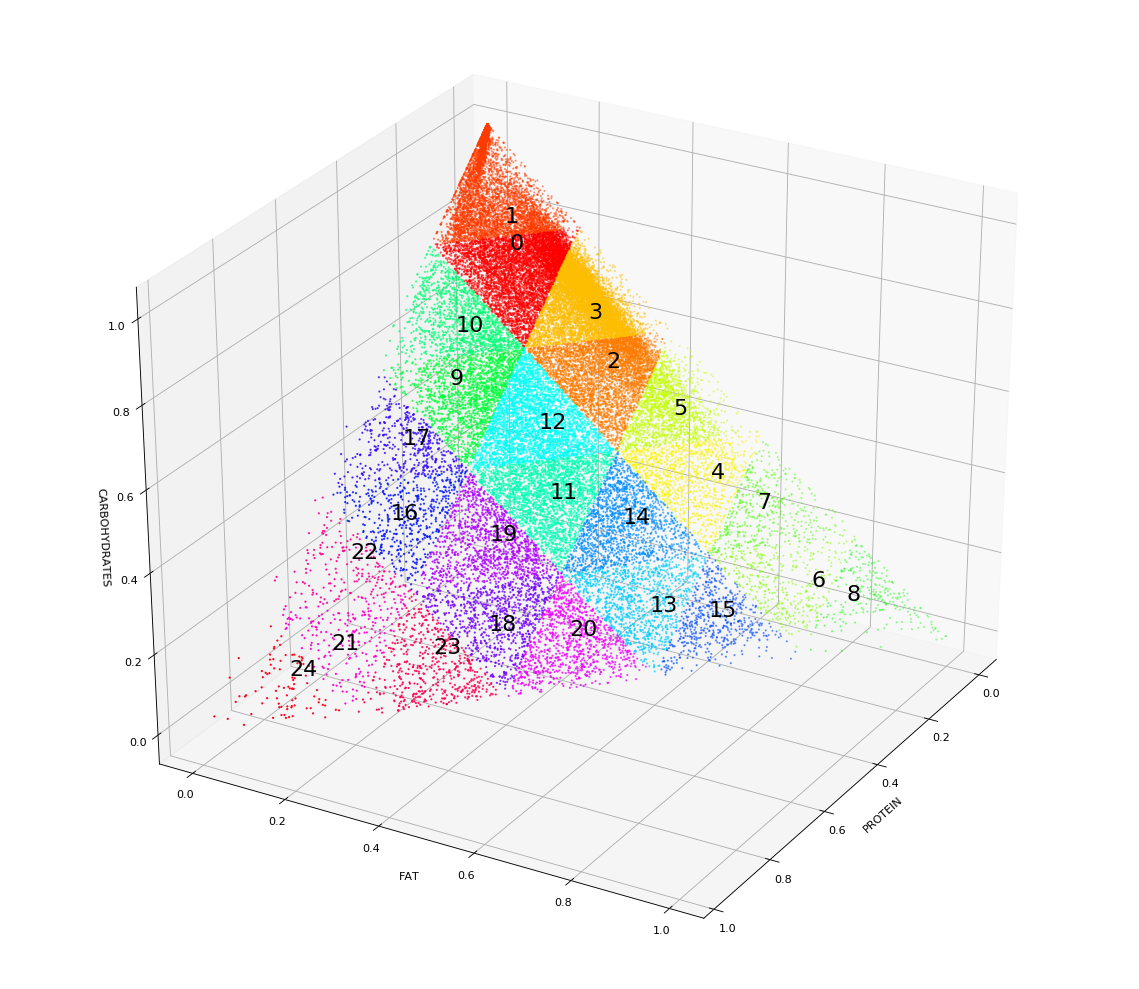

In [8]:
from mpl_toolkits import mplot3d

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')

ax = plt.axes(projection='3d')

ax.view_init(30, 30)

rates = np.array(sdl.get_nutrition_values(classification_id))

# Data for three-dimensional scattered points
rates_x = rates[:,0]
rates_y = rates[:,1]
rates_z = rates[:,2]

rates_c = rates[:,3]
rates_c /= class_count

ax.scatter3D(rates_x, rates_y, rates_z, c=rates_c, cmap='hsv', s=1);

ax.set_xlabel('PROTEIN')
ax.set_ylabel('FAT')
ax.set_zlabel('CARBOHYDRATES')

centroids = np.array(sdl.get_centroids(classification_id)) 

for cd in centroids:
    ax.text(cd[0],cd[1],cd[2],  '%d' % cd[3], size=20, zorder=1, color='k') 

## Building the model

In [9]:
# Set checkpoint save files
top_layers_checkpoint_path = 'cp.top.%s.hdf5' % run_name
fine_tuned_checkpoint_path = 'cp.ftuned.%s.hdf5' % run_name
new_extended_inception_weights = 'weights.%s.hdf5' % run_name

print ("Top layer train checkpoint: %s" % top_layers_checkpoint_path)
print ("Fine tune checkpoint: %s" % fine_tuned_checkpoint_path)
print ("Final weights: %s" % new_extended_inception_weights)

Top layer train checkpoint: cp.top.cid11_tm500_vm500_bs64_te10_te10.hdf5
Fine tune checkpoint: cp.ftuned.cid11_tm500_vm500_bs64_te10_te10.hdf5
Final weights: weights.cid11_tm500_vm500_bs64_te10_te10.hdf5


In [14]:
# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer    # ADDED BY ME
x = Dense(1024, activation='relu')(x)  # ADDED BY ME
# let's add a dropout regularization   # ADDED BY ME
x = Dropout(0.4)(x)                    # ADDED BY ME
# let's add a second fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- we have 125 classes
predictions = Dense(class_count, activation='softmax')(x)

# this is the model we will train
model = Model(input=base_model.input, output=predictions)

if os.path.exists(top_layers_checkpoint_path):
    model.load_weights(top_layers_checkpoint_path)
    print ("Checkpoint '" + top_layers_checkpoint_path + "' loaded.")

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'], )

/home/aleksas/anaconda3/envs/recipes/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Checkpoint 'cp.top.cid11_tm500_vm500_bs64_te10_te10.hdf5' loaded.


### Setup data generators

In [22]:
# Import custom image data generator capable of taking lamda function to load data from SQLite 
from image_ex import ImageDataGeneratorEx

# prepare data augmentation configuration
train_datagen = ImageDataGeneratorEx(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGeneratorEx(rescale=1. / 255)

train_generator = train_datagen.flow_from_database(
    get_class_array=(lambda: sdl.get_condition_indeces(classification_id)),
    get_image_count_by_class=(lambda ci: sdl.get_image_count_by_condition_index(ci, classification_id, train_pr, train_max)),
    get_image_ids_by_class=(lambda ci: sdl.get_image_ids_by_condition_index(ci, classification_id, 0, sdl.get_image_count_by_condition_index(ci, classification_id, train_pr, train_max))),
    get_image_data_by_id=(lambda image_id: sdl.get_image_data_by_id(image_id)),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_database(
    get_class_array=(lambda: sdl.get_condition_indeces(classification_id)),
    get_image_count_by_class=(lambda ci: sdl.get_image_count_by_condition_index(ci, classification_id, valid_pr, val_max)),
    get_image_ids_by_class=(lambda ci: sdl.get_image_ids_by_condition_index(ci, classification_id, sdl.get_image_count_by_condition_index(ci, classification_id, train_pr, train_max), sdl.get_image_count_by_condition_index(ci, classification_id, valid_pr, val_max))),
    get_image_data_by_id=(lambda image_id: sdl.get_image_data_by_id(image_id)),
    batch_size=batch_size,
    class_mode='categorical')

Found 12373 images belonging to 25 classes.
Found 11909 images belonging to 25 classes.


In [23]:
#Save the model after every epoch.
mc_top = ModelCheckpoint(top_layers_checkpoint_path, monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)

#Save the TensorBoard logs.
tb = TensorBoard(log_dir=('./logs/%s'%run_name), histogram_freq=1, write_graph=True, write_images=True)

In [ ]:
# train the model on the new data for a few epochs
model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=top_epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size,
    callbacks=[mc_top, tb])

Epoch 1/10
193/193 [==============================] - 14176s - loss: 3.1721 - acc: 0.1006 - val_loss: 2.8003 - val_acc: 0.1353
Epoch 2/10
193/193 [==============================] - 13954s - loss: 2.9293 - acc: 0.1239 - val_loss: 2.7894 - val_acc: 0.1431
Epoch 3/10
193/193 [==============================] - 14397s - loss: 2.8772 - acc: 0.1419 - val_loss: 2.7826 - val_acc: 0.1484
Epoch 4/10
193/193 [==============================] - 14080s - loss: 2.8479 - acc: 0.1456 - val_loss: 2.7560 - val_acc: 0.1545
Epoch 5/10
193/193 [==============================] - 14290s - loss: 2.8077 - acc: 0.1638 - val_loss: 2.7536 - val_acc: 0.1591
Epoch 6/10
  9/193 [>.............................] - ETA: 8379s - loss: 2.7807 - acc: 0.1703

At this point, the top layers are well trained and we can start fine-tuning convolutional layers from inception V3. We will freeze the bottom N layers and train the remaining top layers.

In [ ]:
# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

In [ ]:
# Save the model after every epoch.
mc_fit = ModelCheckpoint(fine_tuned_checkpoint_path, monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)

# Load saved wights
if os.path.exists(fine_tuned_checkpoint_path):
    model.load_weights(fine_tuned_checkpoint_path)
    print ("Checkpoint '" + fine_tuned_checkpoint_path + "' loaded.")


In [ ]:
# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 172 layers and unfreeze the rest:
for layer in model.layers[:172]:
   layer.trainable = False
for layer in model.layers[172:]:
   layer.trainable = True

In [ ]:
# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
from keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
#model.fit_generator(...)

In [ ]:
model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=fit_epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size,
    callbacks=[mc_fit, tb])

model.save_weights(new_extended_inception_weights)

In [ ]:
model.load_weights(new_extended_inception_weights)

from keras.preprocessing import image as kpi

img = load_img_bytes(sdl.get_image_data_by_id(image_id))
img_tensor = kpi.img_to_array(img)

print(img_tensor.shape)

print(np.expand_dims(img_tensor, axis=0).shape)
print (model.predict(np.expand_dims(img_tensor, axis=0)))
print (np.argmax(model.predict(np.expand_dims(img_tensor, axis=0))))

for ci in range(class_count):
    image_ids = sdl.get_image_ids_by_condition_index(ci, classification_id, 0, 100)
    list_of_tensors = [np.expand_dims(kpi.img_to_array(load_img_bytes(sdl.get_image_data_by_id(image_id))), axis=0) for image_id in image_ids]
    batch = np.vstack(list_of_tensors)    
    
    for image_id, prediction in zip(image_ids, model.predict(batch)):
        print ((ci, image_id, np.argmax(prediction)))